# Ford Go Bike Data Visualisation
## by Pratik Ravikumar Sanghavi

## Investigation Overview

The one crucial question we seek to answer here is for what exactly does our user base utilise our services. For this the following is proposed:-

1. The `Subscriber` group comprises of working individuals that are likely to use our services for work
2. The `Customer` group comprises of a mixed set of users - although they are more poised to use the service for leisure activities on the weekend than the `Subscriber` group
3. There are certainly nodes where the bike concentration either increases or decreases over the course of the month.

## Dataset Overview

The Ford Go Bike trip data from the month of February 2019 is being considered here. It includes data about the trips made by different bikes and captures features such as `duration_sec`, `start_time`, `end_time`, `start_station_id`, `start_station_name`, `start_station_latitude`, `start_station_longitude`, `end_station_id`, `end_station_name`, `end_station_latitude`, `end_station_longitude`, `bike_id`, `user_type`, `member_birth_year`, `member_gender` and `bike_share_for_all_trip`. We can draw several interesting conclusion just from these features as is shown in the subsequent slides  

In [4]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [5]:
# load in the dataset into a pandas dataframe
df_bike_sharing = pd.read_csv('201902-fordgobike-tripdata.csv')

df_bike_sharing_clean = df_bike_sharing.dropna(subset=['start_station_name','end_station_name'])
df_bike_sharing_clean.start_time = pd.to_datetime(df_bike_sharing_clean.start_time)
df_bike_sharing_clean.end_time = pd.to_datetime(df_bike_sharing_clean.end_time)

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

##  Work and Leisure Use Patterns Identified from Data

The very first graph that highlights the pattern typical of a workforce is one shown below

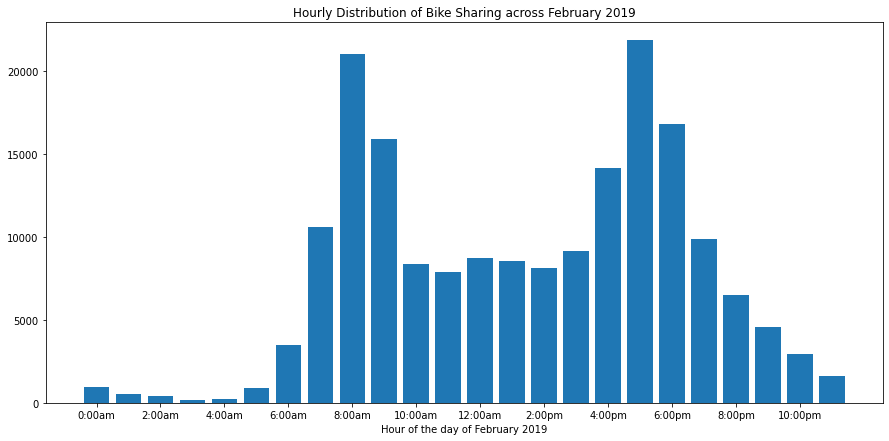

In [6]:
freq_hour_bike = df_bike_sharing_clean.start_time.dt.hour.value_counts().sort_index()
freq_hour_bike = freq_hour_bike.reset_index().drop(columns = 'index')
freq_hour_bike.rename(columns={'start_time':'hour_start'}, inplace=True)

plt.figure(figsize = [15,7])

plt.bar(x = freq_hour_bike.index, height = freq_hour_bike.hour_start);
plt.xlabel("Hour of the day of February 2019");
ticks = range(0,24, 2)
tick_labels = [str(tick) + ":00am" if tick<=12 else str(tick-12) + ":00pm" for tick in ticks]
plt.xticks(ticks, tick_labels, rotation = 0)
plt.title("Hourly Distribution of Bike Sharing across February 2019");

The graph is bimodal with two peaks during rush hours indicative of a predominant use in commuting to and from work. As a matter of fact, the following graph tells us that the demand for our bike falls significantly during weekends.

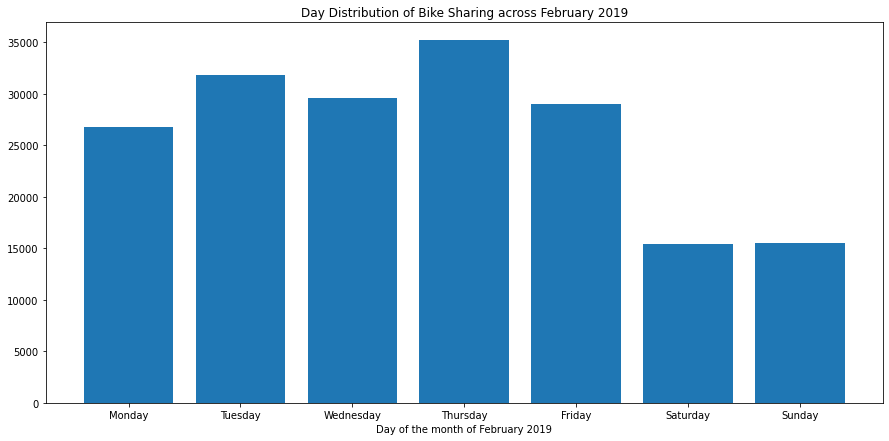

In [8]:
freq_bike = df_bike_sharing_clean.start_time.dt.day_name().value_counts()
freq_bike = freq_bike.reset_index()
freq_bike.rename(columns = {'index': 'Day','start_time':'Day_Ride_Count'}, inplace = True)

weekdays = ['Monday','Tuesday', 'Wednesday','Thursday','Friday','Satubrday','Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
key = freq_bike['Day'].map(mapping)

freq_bike = freq_bike.iloc[key.argsort()].reset_index().drop(columns = 'index')

plt.figure(figsize = [15,7])

plt.bar(x = freq_bike.Day, height = freq_bike.Day_Ride_Count);
plt.xlabel("Day of the month of February 2019");

plt.title("Day Distribution of Bike Sharing across February 2019");

This again draws our attention to the fact that we might be catering to a user base comprising a huge proportion of office workers. Another important feature of our data is that the distribution of ages in our dataset matches the demography of a typical workforce population.

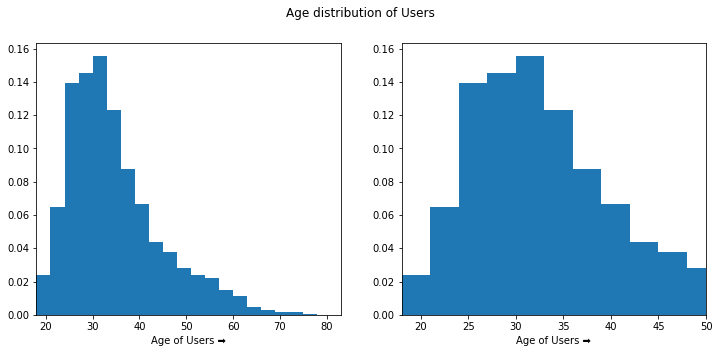

In [11]:
df_bike_sharing_age = df_bike_sharing_clean[df_bike_sharing_clean['member_birth_year'].notnull()].reset_index()

# now compute the age of users. Store in a new column 'member_age'. Since data taken in 2019, this is what will be used for calculation of age
df_bike_sharing_age['member_age'] = 2019 - df_bike_sharing_age['member_birth_year']

df_bike_sharing_age = df_bike_sharing_age[df_bike_sharing_age.member_age <=80].reset_index().drop(columns = ['level_0','index'])
bins = np.arange(df_bike_sharing_age.member_age.min(), df_bike_sharing_age.member_age.max()+3, 3)
df_bike_sharing_age['age_bin'] = pd.cut(df_bike_sharing_age.member_age, bins,)

max_prop_age = df_bike_sharing_age.age_bin.value_counts()[0]/df_bike_sharing_age.age_bin.value_counts().sum()
tick_props = np.arange(0, max_prop_age+0.02, 0.02)
tick_names = ['{:.2f}'.format(v) for v in tick_props]

plt.figure(figsize = [12, 5])
plt.subplot(1,2,1)
plt.hist(data=df_bike_sharing_age, x = 'member_age', bins = bins);
plt.xlim(df_bike_sharing_age.member_age.min(), 83);
plt.xlabel('Age of Users ➡');
plt.yticks(tick_props*df_bike_sharing_age.age_bin.value_counts().sum(), tick_names);
plt.suptitle("Age distribution of Users");

plt.subplot(1,2,2)
plt.hist(data=df_bike_sharing_age, x = 'member_age', bins = bins);
plt.xlim(df_bike_sharing_age.member_age.min(), 50);
plt.yticks(tick_props*df_bike_sharing_age.age_bin.value_counts().sum(), tick_names);
plt.xlabel('Age of Users ➡');

72.63% of our users are between 21-39 years of age which is pretty much the range of ages between which people work at their jobs. All of these seem to indicate a skew towards the possibility of our users using our bikes to commute to work

To identify leisure use patterns, we need to explore some micro-trends in data in different categories

The clustered bar chart below shows that a higher proportion of customers use our services during weekends than the proportion of subscribers.

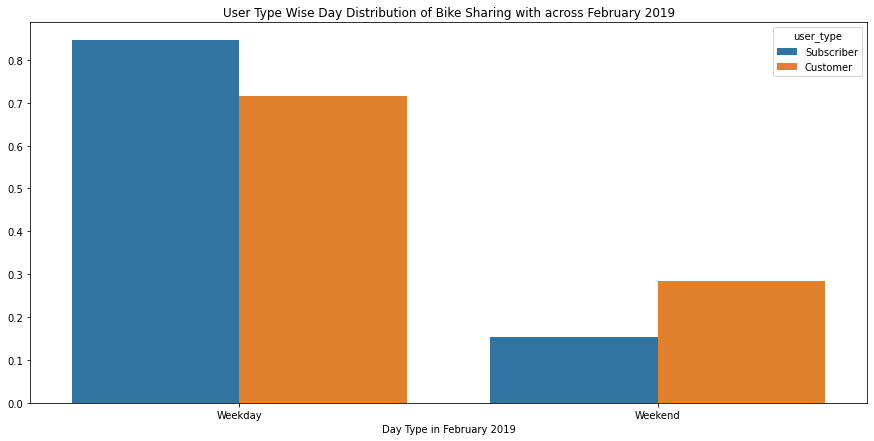

In [12]:
df_bike_sharing_weekday = df_bike_sharing_clean.copy()
df_bike_sharing_weekday['weekday'] = df_bike_sharing_weekday.start_time.dt.weekday
def weekday_classify(x):
    if x <5:
        return "Weekday"
    else:
        return "Weekend"
df_bike_sharing_weekday['day_type'] = [weekday_classify(x) for x in df_bike_sharing_weekday['weekday']]
freq_by_usertype_weekday = df_bike_sharing_weekday.groupby(['day_type','user_type']).size().reset_index()
freq_by_usertype_weekday.columns = ['day_type','user_type','count']
customer_count = df_bike_sharing_clean[df_bike_sharing_clean.user_type == "Customer"].shape[0]
subscriber_count = df_bike_sharing_clean[df_bike_sharing_clean.user_type == "Subscriber"].shape[0]
customer_count, subscriber_count
freq_by_usertype_weekday.loc[0,'count'] = freq_by_usertype_weekday.loc[0,'count']/customer_count
freq_by_usertype_weekday.loc[2,'count'] = freq_by_usertype_weekday.loc[2,'count']/customer_count
freq_by_usertype_weekday.loc[1,'count'] = freq_by_usertype_weekday.loc[1,'count']/subscriber_count
freq_by_usertype_weekday.loc[3,'count'] = freq_by_usertype_weekday.loc[3,'count']/subscriber_count

freq_by_usertype_weekday.rename(columns = {'count':'proportion'}, inplace = True)

plt.figure(figsize = [15,7])
sb.barplot(data=freq_by_usertype_weekday, x = 'day_type', y = 'proportion', hue = 'user_type', hue_order=['Subscriber','Customer'])
plt.xlabel("Day Type in February 2019");
plt.title("User Type Wise Day Distribution of Bike Sharing with across February 2019");
plt.ylabel('');

This coupled with certain other indicators might suggest that we might have more hobbyists among the customers than among the subscribers.

This bar chart reinforces this statement.

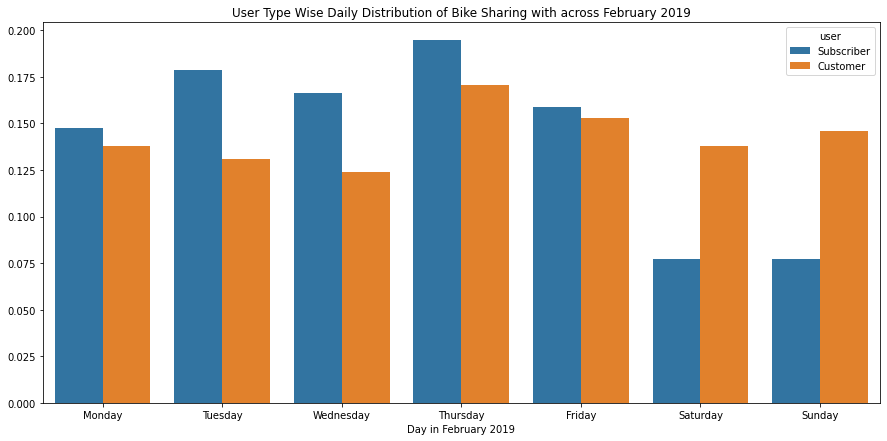

In [13]:
freq_by_usertype_day = df_bike_sharing_weekday.groupby(['weekday','user_type']).size().reset_index()
freq_by_usertype_day.columns = ['day','user_type','count']
def to_prop(freq_by_usertype_day):
    cust_prop = freq_by_usertype_day.query('user_type == "Customer"')['count']/customer_count
    sub_prop = freq_by_usertype_day.query('user_type == "Subscriber"')['count']/subscriber_count
    for i in range(freq_by_usertype_day.shape[0]):
        if i % 2 == 0:
            freq_by_usertype_day.loc[i,'count'] = cust_prop[i]
        else:
            freq_by_usertype_day.loc[i,'count'] = sub_prop[i]
    freq_by_usertype_day.columns = ['day','user','proportion']
    return freq_by_usertype_day
freq_by_usertype_day = to_prop(freq_by_usertype_day)

plt.figure(figsize = [15,7])
sb.barplot(data=freq_by_usertype_day, x = 'day', y = 'proportion', hue = 'user', hue_order = ['Subscriber','Customer'])
plt.xlabel("Day in February 2019");
plt.title("User Type Wise Daily Distribution of Bike Sharing with across February 2019");
plt.xticks([0,1,2,3,4,5,6],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.ylabel('');

To confirm our presupposition that mostly leisurely activities occur during weekends, the following plots have been generated

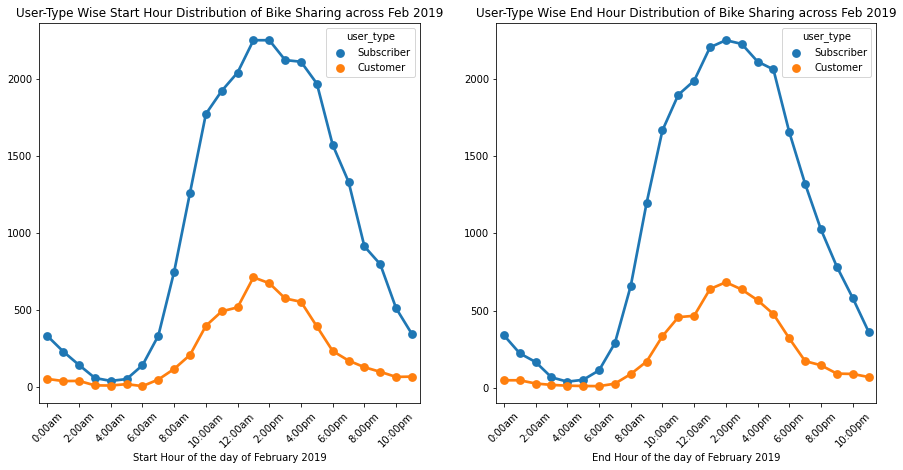

In [14]:
df_bike_sharing_hols = df_bike_sharing_weekday[df_bike_sharing_weekday.day_type == 'Weekend'].copy()
df_bike_sharing_hols['start_hour'] = df_bike_sharing_hols.start_time.dt.hour
df_bike_sharing_hols['end_hour'] = df_bike_sharing_hols.end_time.dt.hour

freq_by_usertype_shols = df_bike_sharing_hols.groupby(['start_hour','user_type']).size().reset_index()
freq_by_usertype_shols.columns = ['hour','user_type','count']

freq_by_usertype_ehols = df_bike_sharing_hols.groupby(['end_hour','user_type']).size().reset_index()
freq_by_usertype_ehols.columns = ['hour','user_type','count']

plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
sb.pointplot(data=freq_by_usertype_shols,x = 'hour', y = 'count', hue = 'user_type', hue_order=['Subscriber','Customer']);
plt.xlabel("Start Hour of the day of February 2019");
ticks = range(0,24, 2)
tick_labels = [str(tick) + ":00am" if tick<=12 else str(tick-12) + ":00pm" for tick in ticks]
plt.xticks(ticks, tick_labels, rotation = 45);
plt.title("User-Type Wise Start Hour Distribution of Bike Sharing across Feb 2019");
plt.ylabel('');

plt.subplot(1,2,2)
sb.pointplot(data=freq_by_usertype_ehols,x = 'hour', y = 'count', hue = 'user_type', hue_order=['Subscriber','Customer']);
plt.xlabel("End Hour of the day of February 2019");
ticks = range(0,24, 2)
tick_labels = [str(tick) + ":00am" if tick<=12 else str(tick-12) + ":00pm" for tick in ticks]
plt.xticks(ticks, tick_labels, rotation = 45);
plt.title("User-Type Wise End Hour Distribution of Bike Sharing across Feb 2019");
plt.ylabel('');

We no longer see the bimodal characteristic of the weekdays implying that our assumption was correct. Furthermore, it also supplements our initial assumption that our `Customer` group has more hobbyists than our `Subscriber` group.

As a final check we have also plotted a heatmap as follows

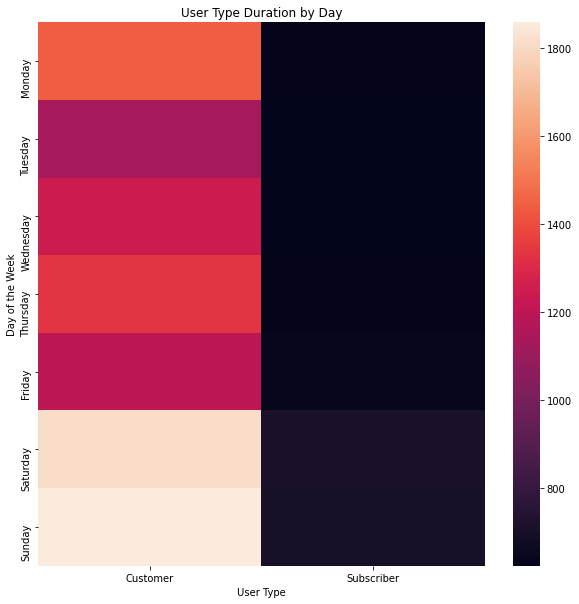

In [15]:
data_user_day_duration = pd.pivot_table(df_bike_sharing_weekday, values = ['duration_sec'], index = ['weekday'], columns = ['user_type'], aggfunc = np.mean)

sb.color_palette('viridis_r')
fig, ax = plt.subplots(figsize=(10,10))
sb.heatmap(data_user_day_duration);
plt.xticks([0.5,1.5],['Customer','Subscriber']);
plt.title('User Type Duration by Day');
plt.xlabel('User Type');
plt.ylabel('Day of the Week')
plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']);

This heatmap reveals an interesting aspect that fits in with our intuitive understanding of leisure trips - they tend to be longer than the routine. Both `Customer` and `Subscriber` groups have longer trip duration on weekends (`Customer` group even more so!). This implies that our assumption about the nature of trip is correct.

We have thus validated two of our three conclusions - the Subscriber group comprising of predominantly working individuals and the Customer group comprising a mixed set of users more prone to use our service for leisure activities on the weekend than the Subscriber group.

## Bike Stockpiles Across Most Frequent Stations during the Month

In this section we will be validating the accumulation or deficit of bikes at the most frequent stations in the dataset in different weeks during the month.

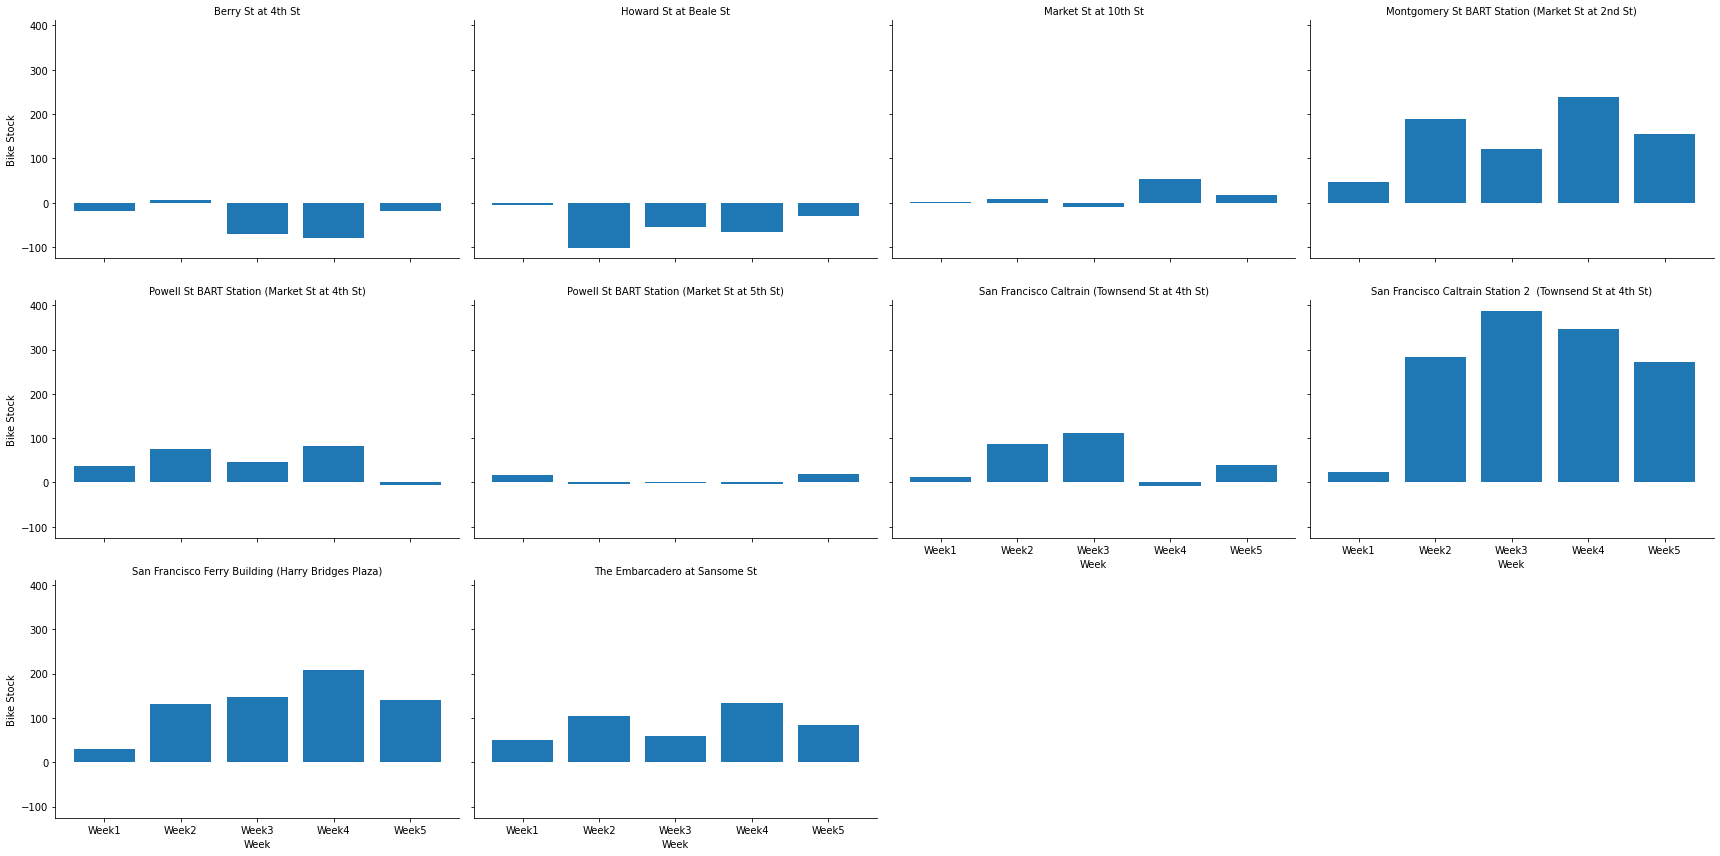

In [17]:
df_bike_sharing_week = df_bike_sharing_clean.copy()
df_bike_sharing_week['start_week'] = df_bike_sharing_week.start_time.dt.isocalendar().week - 5
df_bike_sharing_week['end_week'] = df_bike_sharing_week.end_time.dt.isocalendar().week - 5

df_start_week = df_bike_sharing_week.groupby(['start_week','start_station_name']).size().reset_index().rename(columns = {'start_week': 'week','start_station_name': 'station_name',0:'count'})
df_end_week = df_bike_sharing_week.groupby(['end_week','end_station_name']).size().reset_index().rename(columns = {'end_week': 'week','end_station_name': 'station_name', 0:'count'})
df_merged_entry_exit = df_start_week.merge(df_end_week, on = ['week','station_name'], how = 'outer')
df_merged_entry_exit = df_merged_entry_exit.fillna(0)
df_merged_entry_exit.rename(columns = {'count_x':'exit', 'count_y':'entry'}, inplace=True)
df_merged_entry_exit['difference'] = df_merged_entry_exit['entry'] - df_merged_entry_exit['exit']

# Most frequently occurring 5 stations in start_station and 5 stations in end_stations
stations = []
stations = stations + list(df_bike_sharing_clean.start_station_name.value_counts()[0:9].index)
stations = stations + list(df_bike_sharing_clean.end_station_name.value_counts()[0:9].index)
df_merged_entry_exit_filter = df_merged_entry_exit[df_merged_entry_exit.station_name.isin(stations)]

g = sb.FacetGrid(data = df_merged_entry_exit_filter, col = 'station_name', col_wrap = 4, height=4, aspect= 1.5);
g.map(plt.bar, 'week', 'difference');
g.set_axis_labels("Week", "Bike Stock");
g.set_titles(col_template="{col_name}");
plt.xticks([0,1,2,3,4],['Week1', 'Week2', 'Week3', 'Week4', 'Week5']);

Notice how accumulation of bikes at a station leads to greater accumulation in the subsequent weeks till somehow we observe a drop? We might consider trying to create some sort of equilibrium faster in order to ensure a healthy supply of bikes at the stations. This could be achieved by offering heavy discounts on less frequented routes to our users in hope that they might consider travelling on those routes during their leisure rides. This would benefit them too by enabling them to explore more of the city!! (we might articulate our proposal in our push notification as follows - "Travel the road less travelled at a great price!! Aye, it truly does make a difference.")

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!